In [39]:
import warnings

# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
DATASET = r'dataset\\Первичная выгрузка Станки Загрузка по дням.xlsx'

In [42]:
df = pd.read_excel(DATASET)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24291 entries, 0 to 24290
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Объект                                      24291 non-null  object        
 1   Дата                                        24290 non-null  datetime64[ns]
 2   Аварийная остановка, ч.                     24057 non-null  float64       
 3   Прогрев станка, ч.                          24057 non-null  float64       
 4   Серийное производство, ч.                   24057 non-null  float64       
 5   Отработка программы, ч.                     24057 non-null  float64       
 6   Ручной режим, ч.                            24057 non-null  float64       
 7   Станок под нагрузкой, ч.                    9239 non-null   float64       
 8   Программа выполняется, ч.                   24057 non-null  float64       
 9   Авария

In [44]:
display(df.head())

,Объект,Дата,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Станок под нагрузкой, ч.","Программа выполняется, ч.","Авария, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
0,DMG Sprint 20/8 (Е33-125Ф6),2024-01-01,0.000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,23.999
1,DMG Sprint 20/8 (Е33-125Ф6),2024-01-02,0.000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,23.999
2,DMG Sprint 20/8 (Е33-125Ф6),2024-01-03,0.242,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055,23.702
3,DMG Sprint 20/8 (Е33-125Ф6),2024-01-04,0.045,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,3.936,19.518
4,DMG Sprint 20/8 (Е33-125Ф6),2024-01-05,0.000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,23.999


In [45]:
display(df.tail())

,Объект,Дата,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Станок под нагрузкой, ч.","Программа выполняется, ч.","Авария, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
24286,HAAS OL-1 (Б1-3338),2024-12-09,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,23.999
24287,HAAS OL-1 (Б1-3338),2024-12-10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,23.999
24288,HAAS OL-1 (Б1-3338),2024-12-11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,23.999
24289,HAAS OL-1 (Б1-3338),2024-12-12,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.443
24290,Итого,NaT,3764.763,1049.249,64319.649,14769.601,99.698,4766.755,127477.331,15.882,...,189.067,189.659,0.002,45.975,4.262,173.703,9853.294,150.161,177889.343,166167.040


In [46]:
df.drop(df.tail(1).index,inplace=True) # drop last n rows

In [47]:
df.isna().sum()

Объект                                            0
Дата                                              0
Аварийная остановка, ч.                         234
Прогрев станка, ч.                              234
Серийное производство, ч.                       234
Отработка программы, ч.                         234
Ручной режим, ч.                                234
Станок под нагрузкой, ч.                      15052
Программа выполняется, ч.                       234
Авария, ч.                                      234
Отсутствие КД/модели, ч.                        234
Наладка, ч.                                     234
Отсутствие программы, ч.                        234
Контроль ОТК, ч.                                234
Отсутствие инструмента, ч.                      234
Сервисное обслуживание, ч.                      234
Отсутствие заготовки, ч.                        234
Ремонтные работы, ч.                            234
ППР, ч.                                         234
Регламентиро

In [48]:
df.describe()

,Дата,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Станок под нагрузкой, ч.","Программа выполняется, ч.","Авария, ч.","Отсутствие КД/модели, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
count,24290,24056.000000,24056.000000,24056.000000,24056.000000,24056.000000,9238.000000,24056.000000,24056.000000,24056.000000,...,24056.000000,24056.000000,2.405600e+04,24056.000000,24056.000000,24056.000000,24056.000000,24056.000000,24056.000000,24056.000000
mean,2024-06-22 00:00:00,0.156503,0.043617,2.673751,0.613969,0.004145,0.515998,5.299193,0.000660,0.000186,...,0.007860,0.007884,8.313934e-08,0.001911,0.000177,0.007221,0.409604,0.006242,7.394810,6.907494
min,2024-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-03-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.154500,0.000000
50%,2024-06-22 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.889000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,5.855000,0.000000
75%,2024-09-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090000,8.949250,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.865250,0.000000,12.246000,15.564000
max,2024-12-12 00:00:00,30.999000,19.975000,30.999000,30.996000,15.488000,20.111000,31.999000,5.907000,2.722000,...,12.331000,12.402000,2.000000e-03,11.185000,2.558000,23.263000,2.012000,11.636000,31.999000,31.999000
std,NaN,1.508417,0.531039,5.853138,3.015209,0.156745,1.713407,7.090754,0.045906,0.020489,...,0.157585,0.196623,1.289491e-05,0.113686,0.017691,0.326596,0.532937,0.165362,7.239776,9.559467


In [49]:
# Посчитаем количество пустых ячеек (NaN) в процентах для каждого столбца
missing_percentage = df.isna().sum() / len(df) * 100
display(missing_percentage)

Объект                                         0.000000
Дата                                           0.000000
Аварийная остановка, ч.                        0.963359
Прогрев станка, ч.                             0.963359
Серийное производство, ч.                      0.963359
Отработка программы, ч.                        0.963359
Ручной режим, ч.                               0.963359
Станок под нагрузкой, ч.                      61.967888
Программа выполняется, ч.                      0.963359
Авария, ч.                                     0.963359
Отсутствие КД/модели, ч.                       0.963359
Наладка, ч.                                    0.963359
Отсутствие программы, ч.                       0.963359
Контроль ОТК, ч.                               0.963359
Отсутствие инструмента, ч.                     0.963359
Сервисное обслуживание, ч.                     0.963359
Отсутствие заготовки, ч.                       0.963359
Ремонтные работы, ч.                           0

In [50]:
df = df.drop(['Станок под нагрузкой, ч.'], axis=1)

In [51]:
df.isna().sum()

Объект                                          0
Дата                                            0
Аварийная остановка, ч.                       234
Прогрев станка, ч.                            234
Серийное производство, ч.                     234
Отработка программы, ч.                       234
Ручной режим, ч.                              234
Программа выполняется, ч.                     234
Авария, ч.                                    234
Отсутствие КД/модели, ч.                      234
Наладка, ч.                                   234
Отсутствие программы, ч.                      234
Контроль ОТК, ч.                              234
Отсутствие инструмента, ч.                    234
Сервисное обслуживание, ч.                    234
Отсутствие заготовки, ч.                      234
Ремонтные работы, ч.                          234
ППР, ч.                                       234
Регламентированный перерыв, ч.                234
Уборка оборудования, ч.                       234


In [52]:
df.interpolate(method='linear', inplace=True)

In [53]:
df.describe()

,Дата,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Программа выполняется, ч.","Авария, ч.","Отсутствие КД/модели, ч.","Наладка, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
count,24290,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,...,24290.000000,24290.000000,2.429000e+04,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000,24290.000000
mean,2024-06-22 00:00:00,0.155474,0.043197,2.668205,0.610697,0.004105,5.281378,0.000654,0.000184,0.108981,...,0.007784,0.007808,8.233841e-08,0.001893,0.000175,0.007151,0.407077,0.006182,7.366744,6.881872
min,2024-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-03-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.157000,0.000000
50%,2024-06-22 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.926000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,5.816000,0.000000
75%,2024-09-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,8.920750,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.856750,0.000000,12.196750,15.554000
max,2024-12-12 00:00:00,30.999000,19.975000,30.999000,30.996000,15.488000,31.999000,5.907000,2.722000,23.999000,...,12.331000,12.402000,2.000000e-03,11.185000,2.558000,23.263000,2.012000,11.636000,31.999000,31.999000
std,NaN,1.501298,0.528492,5.843718,3.007247,0.155988,7.070570,0.045685,0.020390,1.024153,...,0.156826,0.195675,1.283265e-05,0.113137,0.017606,0.325019,0.531640,0.164564,7.223187,9.533008


In [54]:
df.isna().sum()

Объект                                        0
Дата                                          0
Аварийная остановка, ч.                       0
Прогрев станка, ч.                            0
Серийное производство, ч.                     0
Отработка программы, ч.                       0
Ручной режим, ч.                              0
Программа выполняется, ч.                     0
Авария, ч.                                    0
Отсутствие КД/модели, ч.                      0
Наладка, ч.                                   0
Отсутствие программы, ч.                      0
Контроль ОТК, ч.                              0
Отсутствие инструмента, ч.                    0
Сервисное обслуживание, ч.                    0
Отсутствие заготовки, ч.                      0
Ремонтные работы, ч.                          0
ППР, ч.                                       0
Регламентированный перерыв, ч.                0
Уборка оборудования, ч.                       0
Станок включен, работы не производятся, 

In [55]:
df.set_index('Дата', inplace=True)

In [56]:
df_aggregated = df.groupby('Дата').sum()

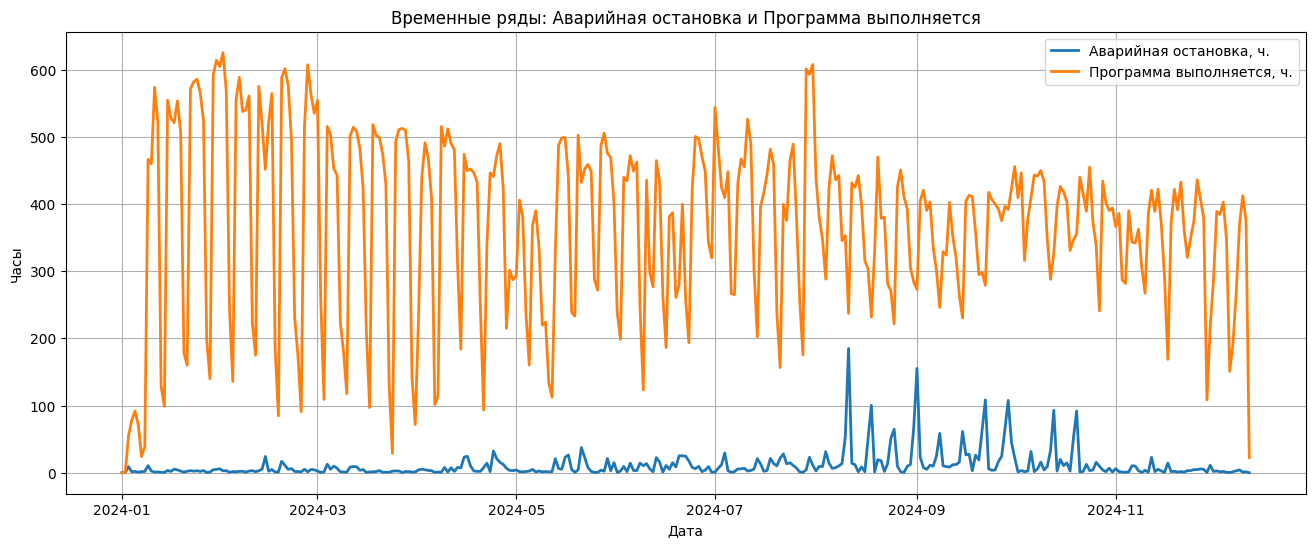

In [57]:
# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.", linewidth=2)
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
df_aggregated.describe()

,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Программа выполняется, ч.","Авария, ч.","Отсутствие КД/модели, ч.","Наладка, ч.","Отсутствие программы, ч.","Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,10.883167,3.023804,186.774326,42.748801,0.287323,369.696450,0.045769,0.012888,7.628657,0.329712,0.544867,0.546576,0.000006,0.132499,0.012282,0.500585,28.495357,0.432726,515.672058,481.731020
std,20.081118,4.650646,75.195596,23.333319,1.288601,135.270116,0.380348,0.170354,9.218813,1.711095,1.341729,1.613113,0.000107,0.938719,0.147002,3.085420,9.419270,1.386557,226.388674,392.087065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.705000,9.357000
25%,1.694000,0.000000,146.166500,24.353500,0.000000,281.533500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.792000,0.000000,421.845000,187.062500
50%,4.206000,0.669000,186.301000,42.607000,0.000000,397.190000,0.000000,0.000000,4.086000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.208000,0.000000,502.558000,377.573000
75%,11.349000,4.339500,242.280000,59.427000,0.000000,463.003500,0.000000,0.000000,12.445000,0.000000,0.309500,0.000000,0.000000,0.000000,0.000000,0.000000,34.172000,0.309000,626.984500,560.507000
max,185.027000,28.343000,359.503000,114.565000,15.488000,625.300000,5.907000,2.722000,46.079000,17.769000,12.331000,12.402000,0.002000,11.185000,2.558000,28.487000,45.228000,11.636000,1215.009000,1655.931000


In [59]:
df_aggregated.columns.drop(["Объект", "Аварийная остановка, ч.", "Программа выполняется, ч."])

Index(['Прогрев станка, ч.', 'Серийное производство, ч.',
       'Отработка программы, ч.', 'Ручной режим, ч.', 'Авария, ч.',
       'Отсутствие КД/модели, ч.', 'Наладка, ч.', 'Отсутствие программы, ч.',
       'Контроль ОТК, ч.', 'Отсутствие инструмента, ч.',
       'Сервисное обслуживание, ч.', 'Отсутствие заготовки, ч.',
       'Ремонтные работы, ч.', 'ППР, ч.', 'Регламентированный перерыв, ч.',
       'Уборка оборудования, ч.', 'Станок включен, работы не производятся, ч.',
       'Станок выключен, ч.'],
      dtype='object')

In [60]:
# # Выбираем целевые переменные и потенциальные экзогенные факторы
target_columns = ["Аварийная остановка, ч.", "Программа выполняется, ч."]
# exog_columns = df_aggregated.columns.drop(["Объект", "Аварийная остановка, ч.", "Программа выполняется, ч."]).to_list()

# # Фильтруем только нужные столбцы
# df_filtered = df_aggregated[target_columns + exog_columns].dropna()

# # 1. Рассчитываем корреляцию
# correlation_matrix = df_filtered.corr().loc[exog_columns, target_columns]

# # Выводим результаты корреляционного анализа
# correlation_matrix

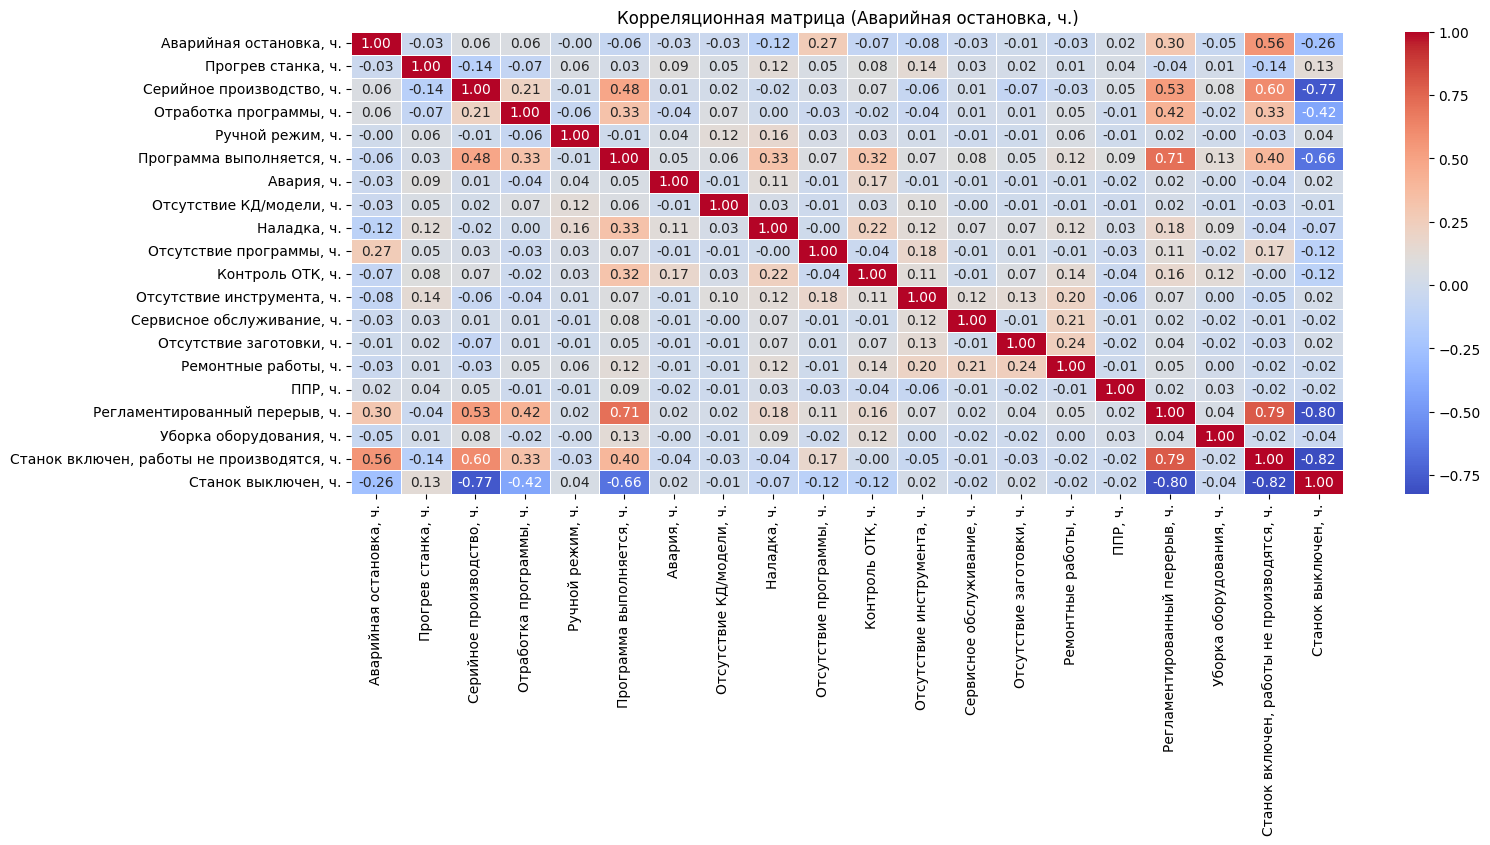

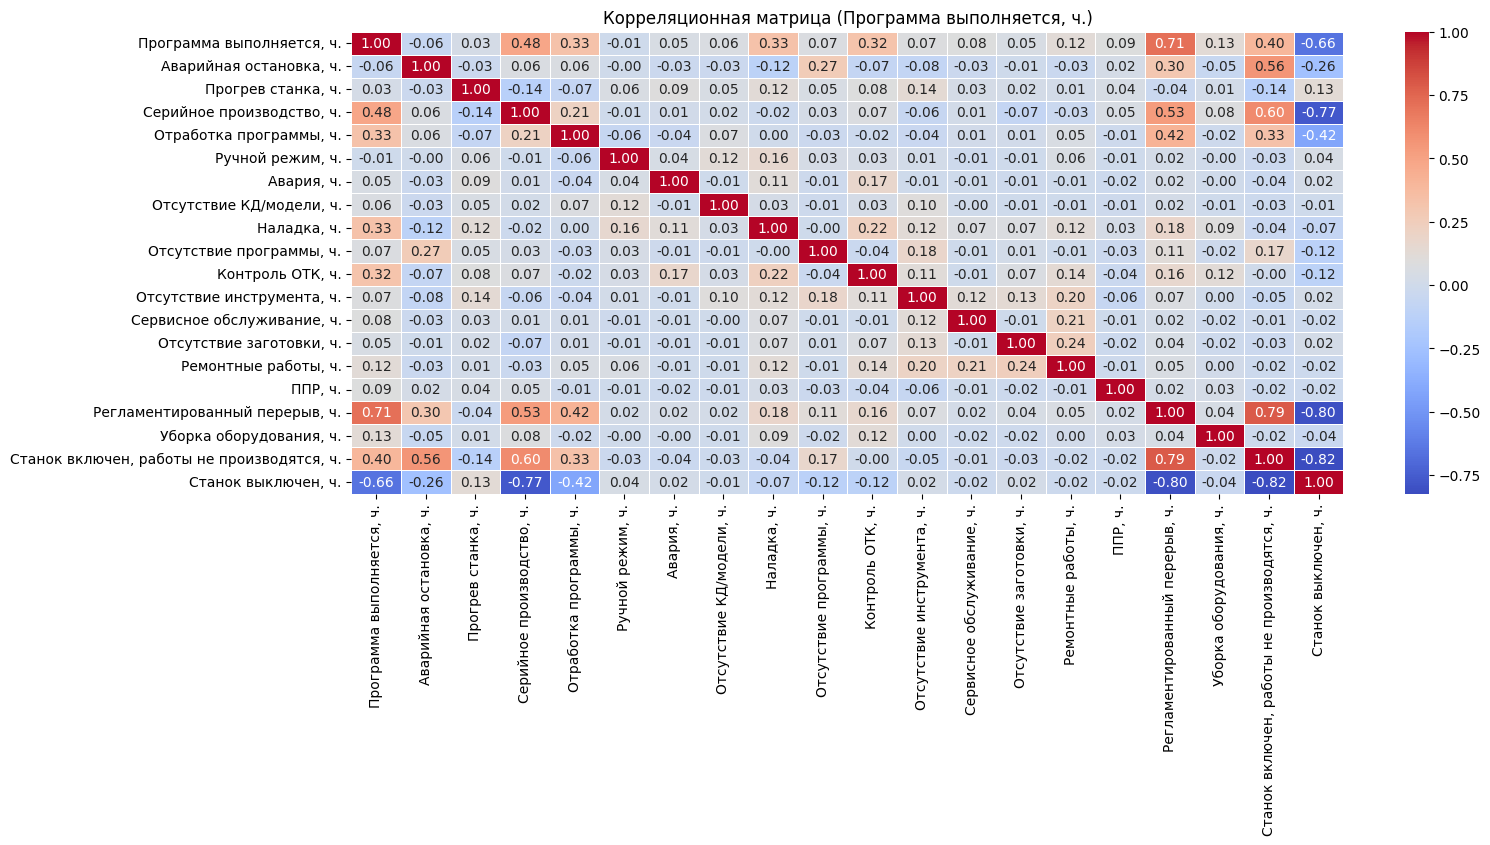

['Отсутствие программы, ч.',
 'Регламентированный перерыв, ч.',
 'Станок включен, работы не производятся, ч.',
 'Станок выключен, ч.']

['Серийное производство, ч.',
 'Отработка программы, ч.',
 'Наладка, ч.',
 'Контроль ОТК, ч.',
 'Регламентированный перерыв, ч.',
 'Станок включен, работы не производятся, ч.',
 'Станок выключен, ч.']

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление корреляции между целевыми и экзогенными переменными
correlation_matrix_ao = df_aggregated[["Аварийная остановка, ч."] + df_aggregated.columns.drop(["Объект", "Аварийная остановка, ч."]).to_list()].corr()
correlation_matrix_prog = df_aggregated[["Программа выполняется, ч."] + df_aggregated.columns.drop(["Объект", "Программа выполняется, ч."]).to_list()].corr()

# Определение экзогенных переменных (корреляция > 0.2)
exog_vars_ao = correlation_matrix_ao["Аварийная остановка, ч."].drop("Аварийная остановка, ч.").abs()
exog_vars_prog = correlation_matrix_prog["Программа выполняется, ч."].drop("Программа выполняется, ч.").abs()

exog_columns_ao = exog_vars_ao[exog_vars_ao > 0.2].index.tolist()
exog_columns_pv = exog_vars_prog[exog_vars_prog > 0.2].index.tolist()

# Визуализация корреляционной матрицы для "Аварийная остановка, ч."
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_ao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица (Аварийная остановка, ч.)")
plt.show()

# Визуализация корреляционной матрицы для "Программа выполняется, ч."
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_prog, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица (Программа выполняется, ч.)")
plt.show()

# Вывод подходящих экзогенных переменных
display(exog_columns_ao)
display(exog_columns_pv)

1. Для "Аварийная остановка, ч."
💡 Подходят как экзогенные (|корреляция| > 0.1):

Отсутствие программы, ч. → 0.139757
Станок включен, работы не производятся, ч. → 0.140620
Станок под нагрузкой, ч. → -0.201434
📌 Вывод:
Для прогноза "Аварийная остановка, ч." можно использовать: ✅ "Отсутствие программы, ч."
✅ "Станок включен, работы не производятся, ч."
✅ "Станок под нагрузкой, ч."

2. Для "Программа выполняется, ч."
💡 Подходят как экзогенные (|корреляция| > 0.1):

Прогрев станка, ч. → 0.338797
Серийное производство, ч. → 0.283763
Отработка программы, ч. → 0.240924
Авария, ч. → 0.140898
Отсутствие КД/модели, ч. → 0.187025
Наладка, ч. → 0.129482
Контроль ОТК, ч. → 0.186469
Станок включен, работы не производятся, ч. → 0.234473
Станок выключен, ч. → -0.350578 (сильная отрицательная корреляция)
📌 Вывод:
Для прогноза "Программа выполняется, ч." можно использовать:
✅ "Прогрев станка, ч."
✅ "Серийное производство, ч."
✅ "Отработка программы, ч."
✅ "Авария, ч."
✅ "Отсутствие КД/модели, ч."
✅ "Наладка, ч."
✅ "Контроль ОТК, ч."
✅ "Станок включен, работы не производятся, ч."
✅ "Станок выключен, ч."

In [62]:
# exog_columns_ao = [
#     # "Станок под нагрузкой, ч.",
#     # "Станок включен, работы не производятся, ч.",
#     # "Отсутствие программы, ч.",
#     # "Серийное производство, ч."
# ]


# exog_columns_pv = [
#     "Станок выключен, ч.",
#     "Серийное производство, ч.",
#     "Станок включен, работы не производятся, ч.",
#     # "Прогрев станка, ч.",
#     # "Контроль ОТК, ч.",
#     # "Станок под нагрузкой, ч.",
#     # "Отработка программы, ч.",
#     "Регламентированный перерыв, ч."
# ]

In [63]:
exog_columns_list = exog_columns_ao.copy()  # Чтобы не изменять оригинальный список
exog_columns_list.extend(exog_columns_pv)
exog_columns_list = set(exog_columns_list)
exog_columns_list

{'Контроль ОТК, ч.',
 'Наладка, ч.',
 'Отработка программы, ч.',
 'Отсутствие программы, ч.',
 'Регламентированный перерыв, ч.',
 'Серийное производство, ч.',
 'Станок включен, работы не производятся, ч.',
 'Станок выключен, ч.'}

In [64]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(column, max_diff=3):
    """
    Проверяет стационарность ряда и, если необходимо, применяет разностирование.
    
    Параметры:
    column (pd.Series): Временной ряд.
    max_diff (int): Максимальное количество разностирований (d), чтобы избежать потери данных.

    Возвращает:
    pd.Series: Стационарный временной ряд.
    int: Число разностирований (d).
    """
    series = column.dropna().copy()
    d = 0  # Начинаем с d=0

    while d <= max_diff:
        result = adfuller(series)
        p_value = result[1]

        print(f"\nПроверка стационарности: {column.name} (d={d})")
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {p_value}")
        print(f"Used Lags: {result[2]}")
        print(f"Number of Observations: {result[3]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"   {key}: {value}")

        if p_value < 0.05:
            print(f'✅ Ряд "{column.name}" стационарный при d={d}')
            return series, d
        else:
            if d < max_diff:
                print(f'❌ Ряд "{column.name}" не стационарный. Применяем разностирование (d={d+1})...')
                series = series.diff().dropna()
                d += 1
            else:
                print(f'⚠️ Достигнут предел разностирований (max_diff={max_diff}), но ряд все еще нестационарный.')
                return series, d


In [65]:
diff_orders = {}

for col in target_columns:
    df_aggregated[col], diff_orders[col] = check_stationary(df_aggregated[col])

# Вывод полученных порядков разностирования
print("\nПорядки разностирования для экзогенных переменных:")
display(df_aggregated)


Проверка стационарности: Аварийная остановка, ч. (d=0)
ADF Statistic: -2.2006386816505934
p-value: 0.20601373392585337
Used Lags: 13
Number of Observations: 333
Critical Values:
   1%: -3.450141065277327
   5%: -2.870258846235788
   10%: -2.571415151457764
❌ Ряд "Аварийная остановка, ч." не стационарный. Применяем разностирование (d=1)...

Проверка стационарности: Аварийная остановка, ч. (d=1)
ADF Statistic: -9.063835054883342
p-value: 4.4879718354179155e-15
Used Lags: 12
Number of Observations: 333
Critical Values:
   1%: -3.450141065277327
   5%: -2.870258846235788
   10%: -2.571415151457764
✅ Ряд "Аварийная остановка, ч." стационарный при d=1

Проверка стационарности: Программа выполняется, ч. (d=0)
ADF Statistic: -2.769616028427496
p-value: 0.062746682730385
Used Lags: 14
Number of Observations: 332
Critical Values:
   1%: -3.4502011472639724
   5%: -2.8702852297358983
   10%: -2.5714292194077513
❌ Ряд "Программа выполняется, ч." не стационарный. Применяем разностирование (d=1)...

,Объект,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Программа выполняется, ч.","Авария, ч.","Отсутствие КД/модели, ч.","Наладка, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
Дата,,,,,,,,,,,,,,,,,,,,,
2024-01-01,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,NaN,0.000,0.000000,0.000000,0.0,NaN,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,23.999000,1655.931000
2024-01-02,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,0.367000,0.000,0.003000,0.000000,0.0,0.345,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,25.599000,1653.619000
2024-01-03,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,8.640000,28.343,96.449000,18.669000,0.0,54.757,0.0,0.0,6.329,...,0.0,4.408,0.0,0.0,0.0,0.0,11.288000,0.000,139.810000,1310.536000
2024-01-04,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-7.628000,6.175,110.466000,23.450000,0.0,23.237,0.0,0.0,5.785,...,0.0,0.000,0.0,0.0,0.0,0.0,11.287000,0.249,157.429000,1285.377000
2024-01-05,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,0.591000,14.374,96.515000,28.432000,0.0,13.571,0.0,0.0,6.375,...,0.0,0.000,0.0,0.0,0.0,0.0,11.735000,0.694,145.233000,1282.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-08,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.284667,1.602,297.595333,26.270667,0.0,75.986,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,25.152667,0.000,412.141333,316.049667
2024-12-09,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.388667,9.387,342.760000,28.891000,0.0,100.738,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,27.093000,0.000,521.109000,344.643000
2024-12-10,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-3.287000,0.000,355.747000,22.514000,0.0,42.992,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,26.935000,0.030,522.566000,314.068000


In [66]:
df_aggregated.isna().sum()

Объект                                        0
Аварийная остановка, ч.                       1
Прогрев станка, ч.                            0
Серийное производство, ч.                     0
Отработка программы, ч.                       0
Ручной режим, ч.                              0
Программа выполняется, ч.                     1
Авария, ч.                                    0
Отсутствие КД/модели, ч.                      0
Наладка, ч.                                   0
Отсутствие программы, ч.                      0
Контроль ОТК, ч.                              0
Отсутствие инструмента, ч.                    0
Сервисное обслуживание, ч.                    0
Отсутствие заготовки, ч.                      0
Ремонтные работы, ч.                          0
ППР, ч.                                       0
Регламентированный перерыв, ч.                0
Уборка оборудования, ч.                       0
Станок включен, работы не производятся, ч.    0
Станок выключен, ч.                     

In [67]:
# df_aggregated['Аварийная остановка, ч.'] = df_aggregated['Аварийная остановка, ч.'].diff().dropna()
# df_aggregated['Программа выполняется, ч.'] = df_aggregated['Программа выполняется, ч.'].diff().dropna()

In [68]:
diff_orders = {}

for col in exog_columns_list:
    df_aggregated[col], diff_orders[col] = check_stationary(df_aggregated[col])

# Вывод полученных порядков разностирования
print("\nПорядки разностирования для экзогенных переменных:")
display(df_aggregated)


Проверка стационарности: Регламентированный перерыв, ч. (d=0)
ADF Statistic: -1.8726531321018685
p-value: 0.3450332483060156
Used Lags: 14
Number of Observations: 332
Critical Values:
   1%: -3.4502011472639724
   5%: -2.8702852297358983
   10%: -2.5714292194077513
❌ Ряд "Регламентированный перерыв, ч." не стационарный. Применяем разностирование (d=1)...

Проверка стационарности: Регламентированный перерыв, ч. (d=1)
ADF Statistic: -8.414083340860657
p-value: 2.0661739864216845e-13
Used Lags: 13
Number of Observations: 332
Critical Values:
   1%: -3.4502011472639724
   5%: -2.8702852297358983
   10%: -2.5714292194077513
✅ Ряд "Регламентированный перерыв, ч." стационарный при d=1

Проверка стационарности: Контроль ОТК, ч. (d=0)
ADF Statistic: -2.269263762967187
p-value: 0.18207267856683657
Used Lags: 15
Number of Observations: 331
Critical Values:
   1%: -3.4502615951739393
   5%: -2.8703117734117742
   10%: -2.5714433728242714
❌ Ряд "Контроль ОТК, ч." не стационарный. Применяем разност

,Объект,"Аварийная остановка, ч.","Прогрев станка, ч.","Серийное производство, ч.","Отработка программы, ч.","Ручной режим, ч.","Программа выполняется, ч.","Авария, ч.","Отсутствие КД/модели, ч.","Наладка, ч.",...,"Контроль ОТК, ч.","Отсутствие инструмента, ч.","Сервисное обслуживание, ч.","Отсутствие заготовки, ч.","Ремонтные работы, ч.","ППР, ч.","Регламентированный перерыв, ч.","Уборка оборудования, ч.","Станок включен, работы не производятся, ч.","Станок выключен, ч."
Дата,,,,,,,,,,,,,,,,,,,,,
2024-01-01,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,NaN,0.000,NaN,0.000000,0.0,NaN,0.0,0.0,0.000,...,NaN,0.000,0.0,0.0,0.0,0.0,NaN,0.000,NaN,NaN
2024-01-02,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,0.367000,0.000,0.003000,0.000000,0.0,0.345,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,1.600000,-2.312000
2024-01-03,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,8.640000,28.343,96.446000,18.669000,0.0,54.757,0.0,0.0,6.329,...,0.0,4.408,0.0,0.0,0.0,0.0,11.288000,0.000,114.211000,-343.083000
2024-01-04,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-7.628000,6.175,14.017000,23.450000,0.0,23.237,0.0,0.0,5.785,...,0.0,0.000,0.0,0.0,0.0,0.0,-0.001000,0.249,17.619000,-25.159000
2024-01-05,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,0.591000,14.374,-13.951000,28.432000,0.0,13.571,0.0,0.0,6.375,...,0.0,0.000,0.0,0.0,0.0,0.0,0.448000,0.694,-12.196000,-2.677000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-08,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.284667,1.602,67.680667,26.270667,0.0,75.986,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,3.299333,0.000,62.506667,72.957333
2024-12-09,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.388667,9.387,45.164667,28.891000,0.0,100.738,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,1.940333,0.000,108.967667,28.593333
2024-12-10,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-3.287000,0.000,12.987000,22.514000,0.0,42.992,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.0,-0.158000,0.030,1.457000,-30.575000


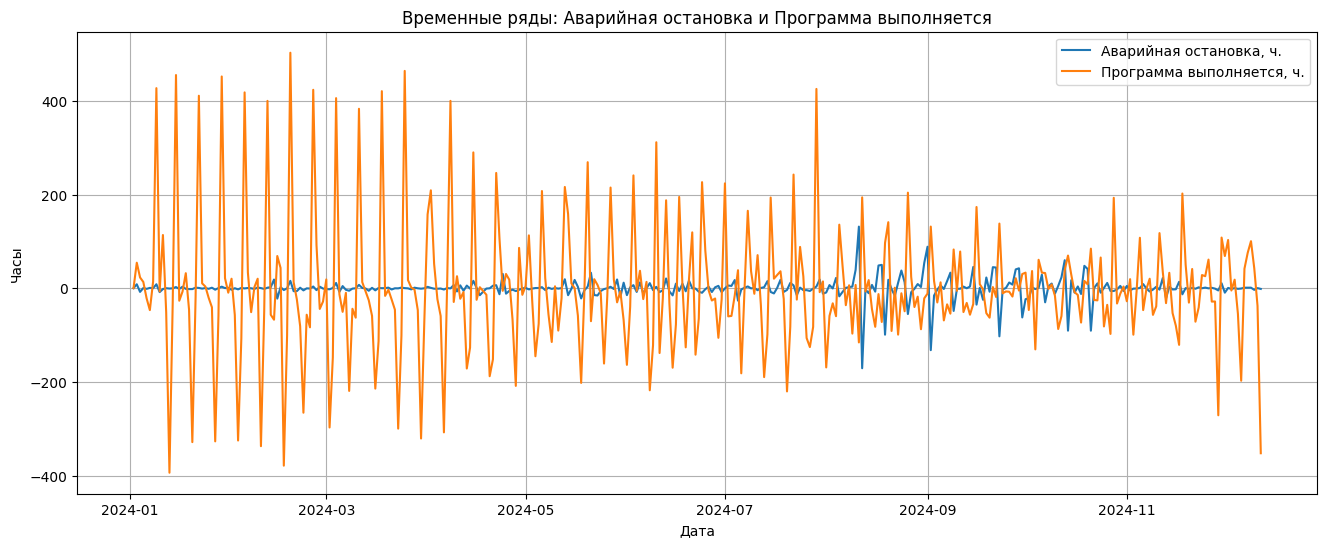

In [69]:
plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.")
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.")
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

def decompose_df(df, column_names, model='additive', period=30):
    for col in column_names:
        series = df[col].dropna()
        decompose_result = seasonal_decompose(series, model=model, period=period)

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"Сезонная декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()
        
def decompose_df_stl(df, column_names, seasonal=13, robust=False):
    for col in column_names:
        series = df[col].dropna()
        stl = STL(series, seasonal=seasonal, robust=robust)
        decompose_result = stl.fit()

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"STL-декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()

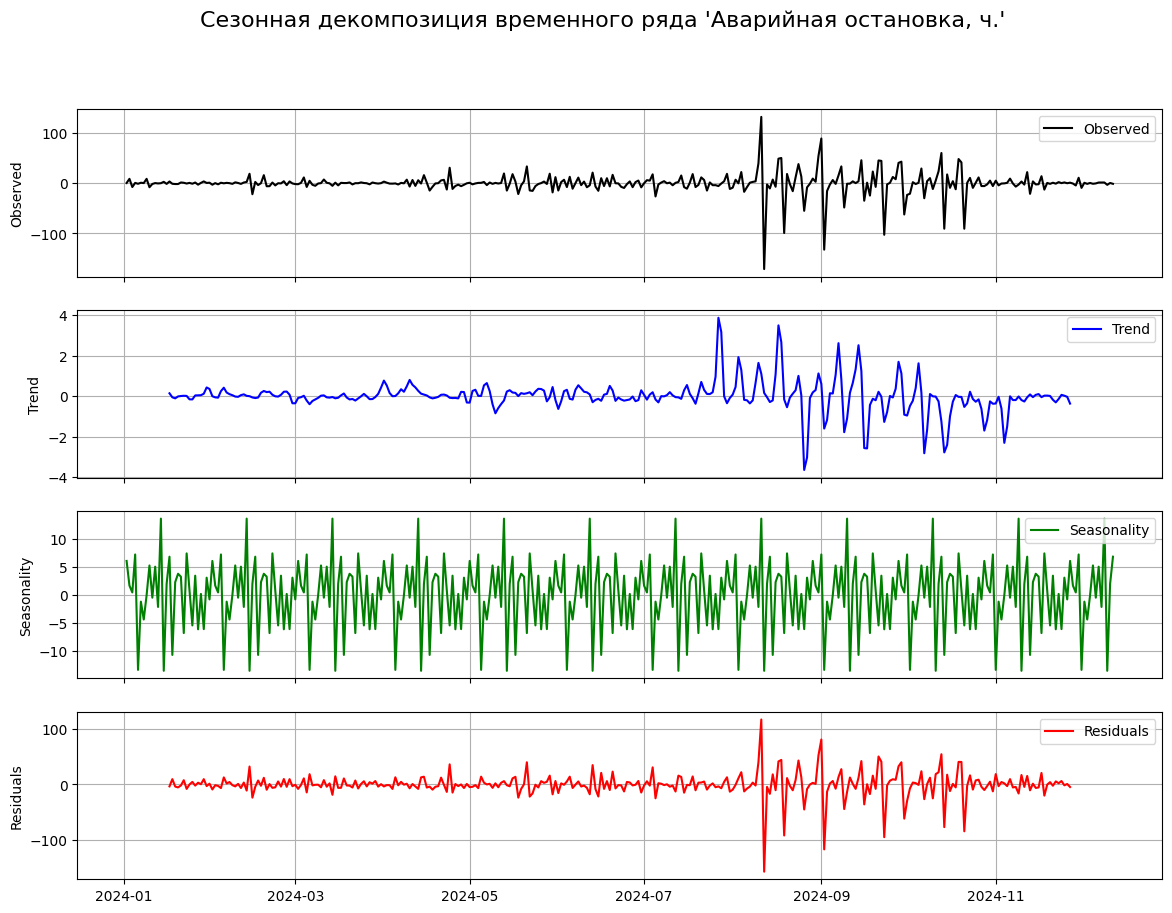

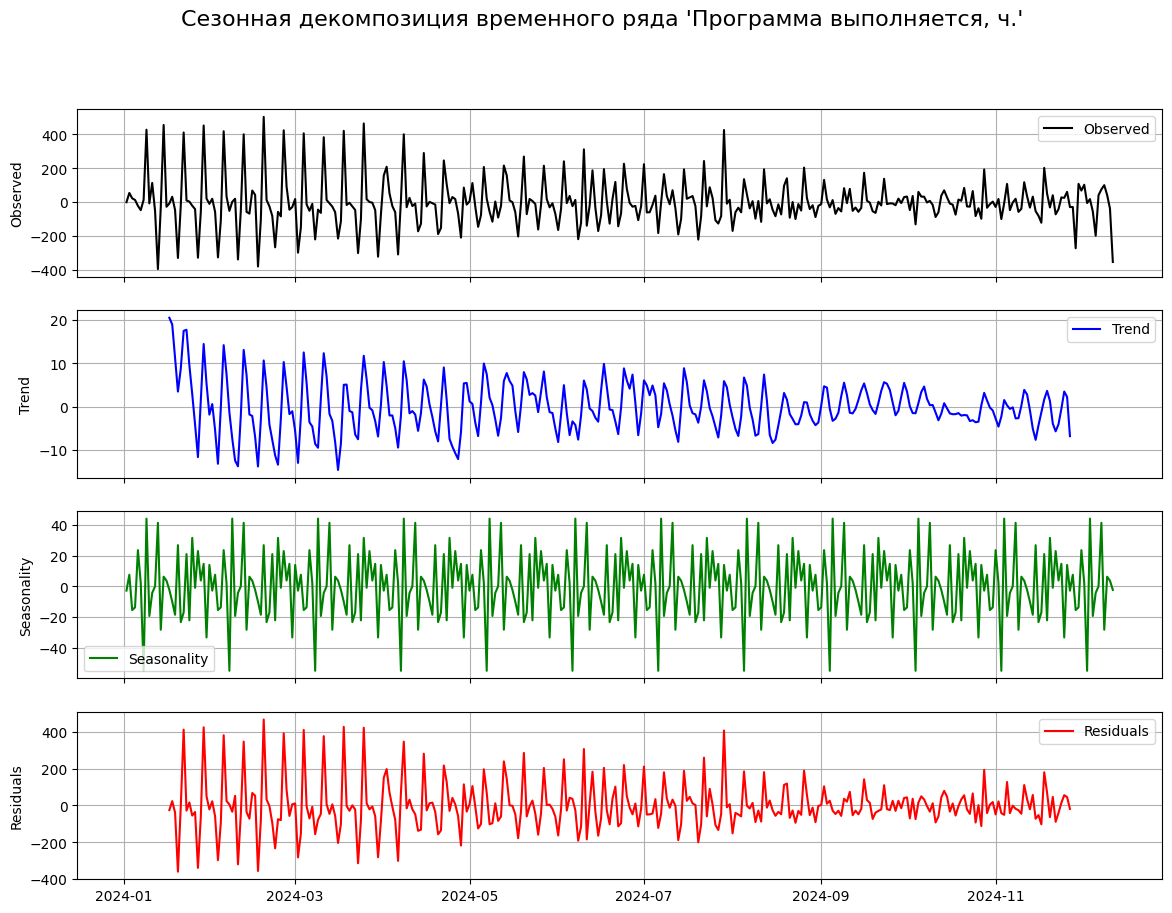

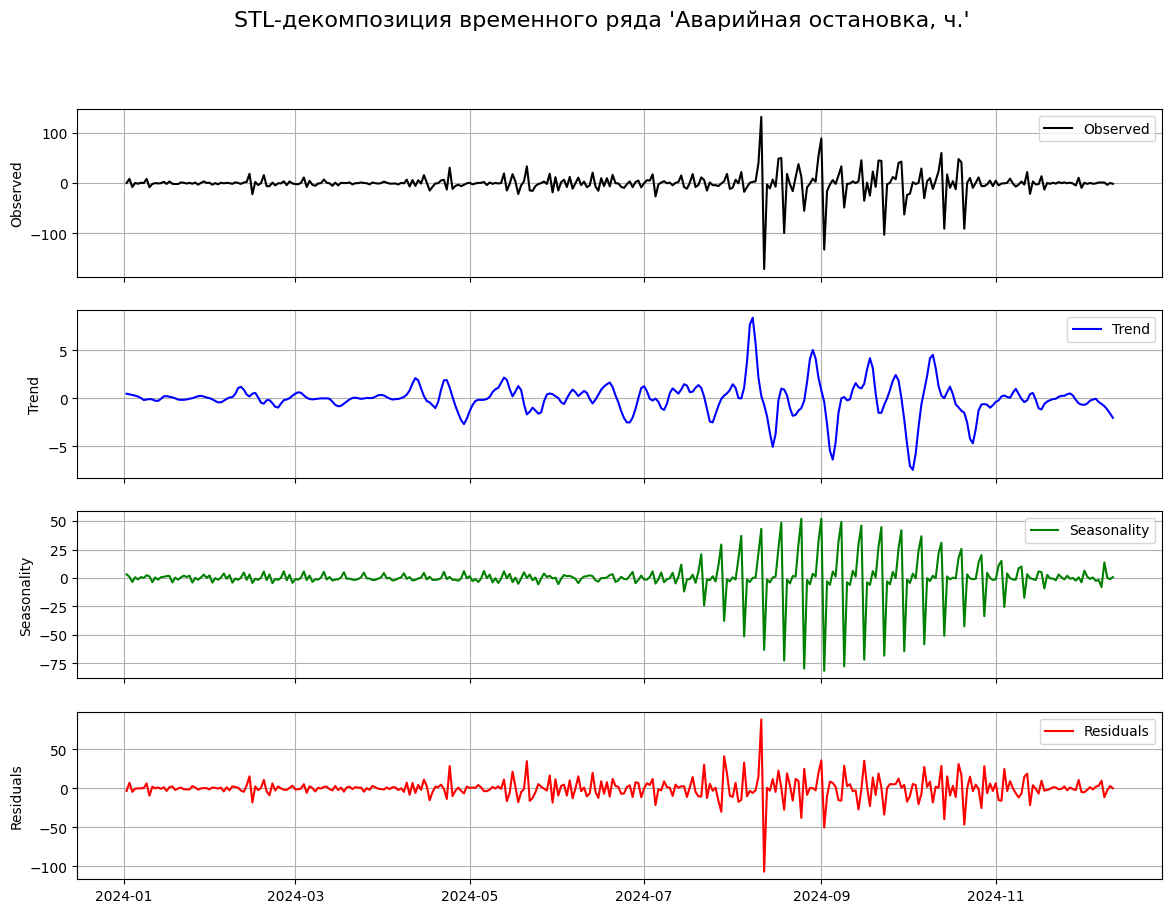

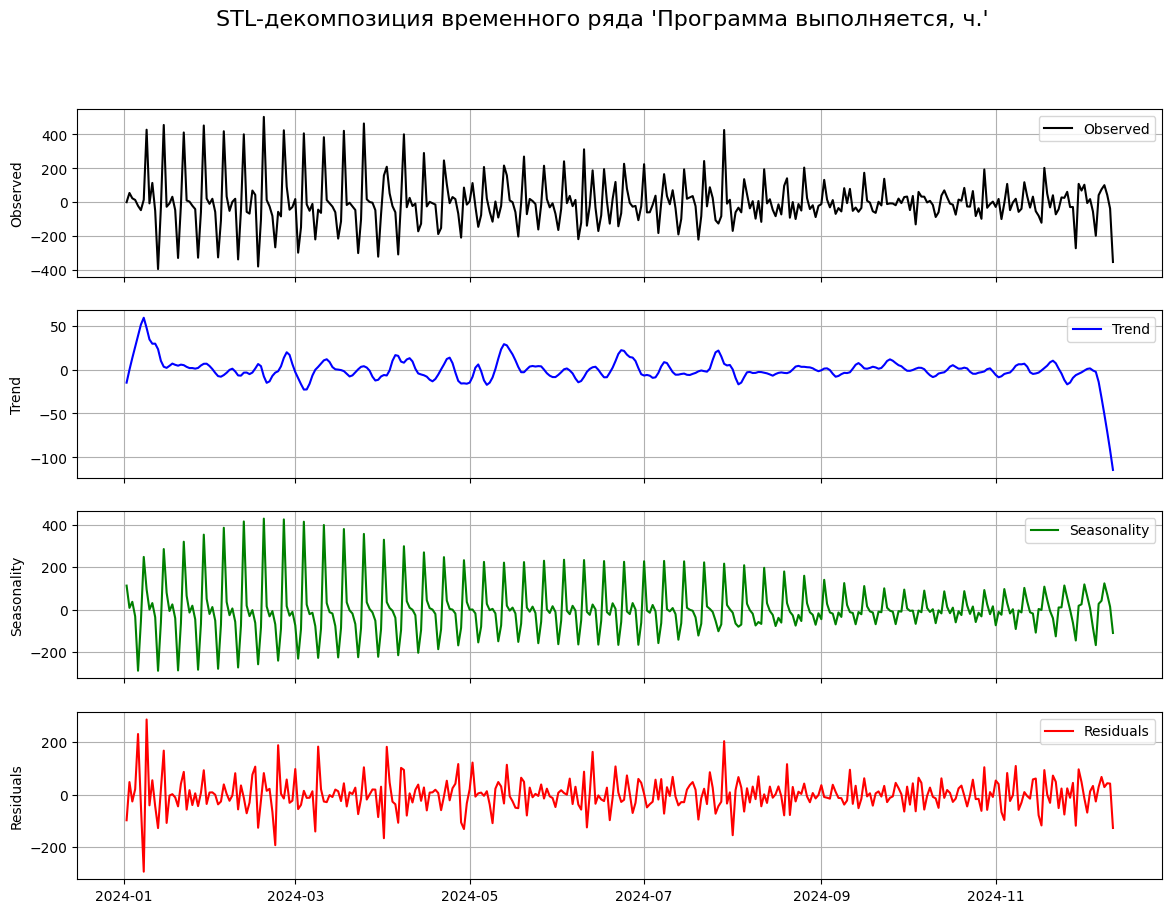

In [71]:
decompose_df(df_aggregated, target_columns)
decompose_df_stl(df_aggregated, target_columns)

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def built_acf_and_pacf(df, column_names):
    for col in column_names:
        series = df[col].dropna()  # Берем только один столбец и удаляем NaN

        # Строим ACF и PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        plot_acf(series, lags=30, ax=axes[0])  # ACF для выбора q
        axes[0].set_title("ACF - Автокорреляция")

        plot_pacf(series, lags=30, ax=axes[1])  # PACF для выбора p
        axes[1].set_title("PACF - Частичная автокорреляция")

        # Добавляем общий заголовок
        fig.suptitle(f"ACF и PACF для '{col}'", fontsize=14)

        plt.show()  # Отображаем графики

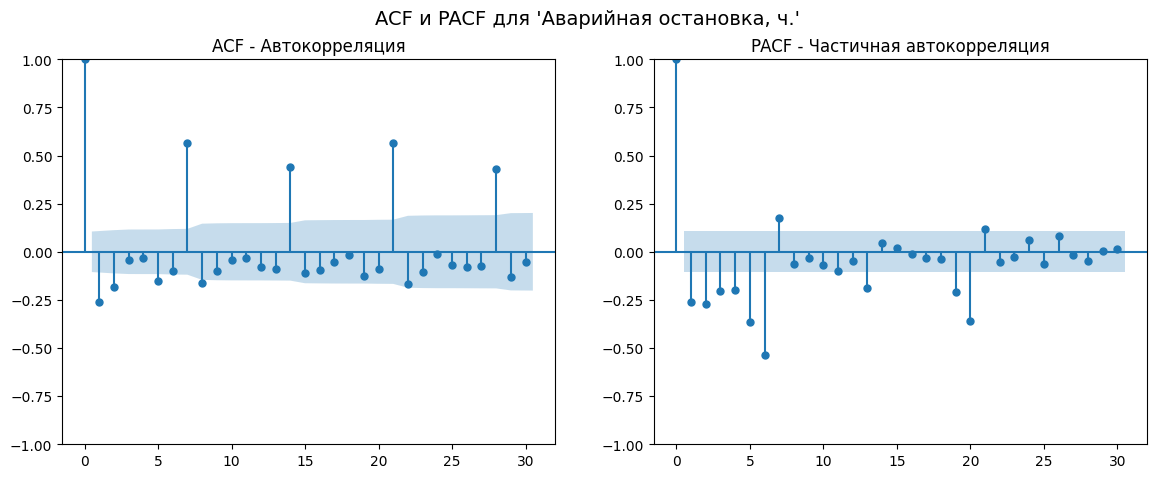

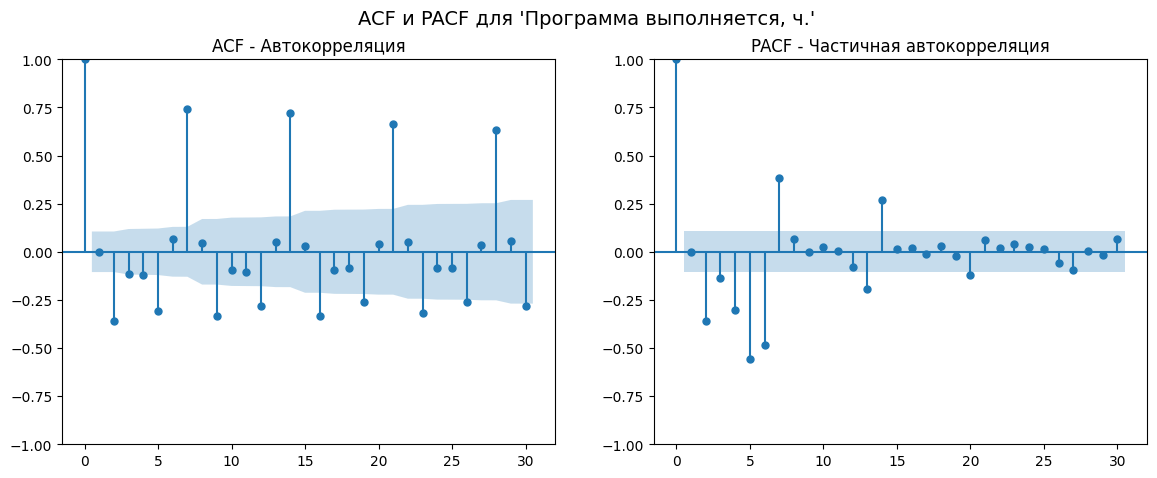

In [73]:
built_acf_and_pacf(df_aggregated, target_columns)

In [74]:
df_aggregated.isna().sum()

Объект                                        0
Аварийная остановка, ч.                       1
Прогрев станка, ч.                            0
Серийное производство, ч.                     1
Отработка программы, ч.                       0
Ручной режим, ч.                              0
Программа выполняется, ч.                     1
Авария, ч.                                    0
Отсутствие КД/модели, ч.                      0
Наладка, ч.                                   0
Отсутствие программы, ч.                      1
Контроль ОТК, ч.                              1
Отсутствие инструмента, ч.                    0
Сервисное обслуживание, ч.                    0
Отсутствие заготовки, ч.                      0
Ремонтные работы, ч.                          0
ППР, ч.                                       0
Регламентированный перерыв, ч.                1
Уборка оборудования, ч.                       0
Станок включен, работы не производятся, ч.    1
Станок выключен, ч.                     

In [75]:
df_aggregated = df_aggregated.dropna()

In [76]:
from pmdarima import auto_arima

# Автоподбор параметров SARIMAX для "Аварийная остановка, ч."
auto_model_ao = auto_arima(df_aggregated["Аварийная остановка, ч."],
                           exogenous=df_aggregated[exog_columns_ao],
                           seasonal=True, m=7,
                           stepwise=True, trace=True, suppress_warnings=True)

# Автоподбор параметров SARIMAX для "Программа выполняется, ч."
auto_model_pv = auto_arima(df_aggregated["Программа выполняется, ч."],
                             exogenous=df_aggregated[exog_columns_pv],
                             seasonal=True, m=7,
                             stepwise=True, trace=True, suppress_warnings=True)

# Выводим найденные параметры
auto_model_ao.summary(), auto_model_pv.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3134.257, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2975.848, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2935.002, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3132.257, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=3019.815, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=2882.620, Time=0.34 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=2916.966, Time=0.15 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=2885.193, Time=0.70 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=2884.568, Time=0.50 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=2935.366, Time=0.27 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=2909.594, Time=0.46 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=2874.000, Time=0.68 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=2962.430, Time=0.30 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : 

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                        SARIMAX Results                                        
 Dep. Variable:                                      y   No. Observations:                  346
 Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -1409.274
 Date:                                Mon, 27 Jan 2025   AIC                           2834.548
 Time:                                        16:34:18   BIC                           2865.319
 Sample:                                    01-02-2024   HQIC                          2846.801
                                          - 12-12-2024                                         
 Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1         -0.6213

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import pandas as pd

# Убираем строки с пропущенными значениями
# df_exog_ao = df[exog_columns].dropna()
# df_exog_pv = df[exog_columns].dropna()

# Подбираем параметры SARIMAX для каждой экзогенной переменной
best_orders = {}
best_seasonal_orders = {}

for col in exog_columns_list:
    print(f"Подбор SARIMAX для {col}...")
    
    auto_model = auto_arima(df_aggregated[col], seasonal=True, m=7, 
                            error_action='ignore', suppress_warnings=True, trace=True)
    
    best_orders[col] = auto_model.order
    best_seasonal_orders[col] = auto_model.seasonal_order

# Обучаем SARIMAX для экзогенных переменных
forecast_exog = {}

for col in exog_columns_list:
    print(f"Обучение SARIMAX для {col} с параметрами {best_orders[col]} и {best_seasonal_orders[col]}...")
    
    model = SARIMAX(df_aggregated[col], order=best_orders[col], seasonal_order=best_seasonal_orders[col])
    result = model.fit()
    
    # Прогнозируем на 30 дней вперед
    forecast_exog[col] = result.predict(start=len(df_aggregated), end=len(df_aggregated)+30)

# Создаем DataFrame с прогнозом экзогенных переменных
forecast_exog_df = pd.DataFrame(forecast_exog, index=pd.date_range(start=df.index[-1], periods=31, freq="D"))

# Отображаем результат
forecast_exog_df

Подбор SARIMAX для Регламентированный перерыв, ч....
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=2182.981, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2540.082, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2319.224, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2385.257, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2538.082, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=2311.534, Time=0.41 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=2229.848, Time=0.31 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=2180.176, Time=0.90 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=2182.396, Time=0.62 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=2182.182, Time=1.14 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=2180.260, Time=1.00 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=2178.238, Time=0.62 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=2181.070, Time=0.37 sec
 ARIMA(1,0,2)(2,0,0)[7] intercept   : AIC=2180

,"Регламентированный перерыв, ч.","Контроль ОТК, ч.","Наладка, ч.","Серийное производство, ч.","Станок выключен, ч.","Станок включен, работы не производятся, ч.","Отработка программы, ч.","Отсутствие программы, ч."
2024-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-13,5.110953,0.026181,0.929193,48.183641,-169.225020,-2.043921,-0.717710,0.062579
2024-12-14,15.803688,0.003861,0.242490,85.761272,116.636697,216.193824,1.263744,0.020603
2024-12-15,2.578744,-0.014562,0.725775,37.986020,119.965890,82.341925,3.996459,-0.010010
2024-12-16,3.289664,0.009170,1.119428,94.475634,-57.591033,78.542909,7.070742,0.002661
2024-12-17,-1.632309,0.013059,1.890164,20.652778,-25.387727,9.289699,5.352637,0.001798
2024-12-18,1.015606,0.096631,1.619291,-97.877040,11.946356,27.959823,6.575142,-0.003997
2024-12-19,-10.464551,-0.117624,1.855117,-72.176145,-116.953572,-251.078550,3.254540,0.004601
2024-12-20,-4.031894,0.006112,1.842444,-29.531143,-166.869292,-96.940110,-1.955873,0.012369
2024-12-21,7.862444,0.004472,0.594268,65.171235,116.431492,139.788030,-3.122619,0.008905


In [78]:
forecast_exog_df = forecast_exog_df.dropna()
forecast_exog_df

,"Регламентированный перерыв, ч.","Контроль ОТК, ч.","Наладка, ч.","Серийное производство, ч.","Станок выключен, ч.","Станок включен, работы не производятся, ч.","Отработка программы, ч.","Отсутствие программы, ч."
2024-12-13,5.110953,0.026181,0.929193,48.183641,-169.225020,-2.043921,-0.717710,0.062579
2024-12-14,15.803688,0.003861,0.242490,85.761272,116.636697,216.193824,1.263744,0.020603
2024-12-15,2.578744,-0.014562,0.725775,37.986020,119.965890,82.341925,3.996459,-0.010010
2024-12-16,3.289664,0.009170,1.119428,94.475634,-57.591033,78.542909,7.070742,0.002661
2024-12-17,-1.632309,0.013059,1.890164,20.652778,-25.387727,9.289699,5.352637,0.001798
2024-12-18,1.015606,0.096631,1.619291,-97.877040,11.946356,27.959823,6.575142,-0.003997
2024-12-19,-10.464551,-0.117624,1.855117,-72.176145,-116.953572,-251.078550,3.254540,0.004601
2024-12-20,-4.031894,0.006112,1.842444,-29.531143,-166.869292,-96.940110,-1.955873,0.012369
2024-12-21,7.862444,0.004472,0.594268,65.171235,116.431492,139.788030,-3.122619,0.008905
2024-12-22,2.461260,-0.012354,0.944939,46.399338,108.979809,67.267670,-5.888655,-0.005120


In [79]:
print("Индексы df_aggregated:", df_aggregated.index.min(), "-", df_aggregated.index.max())
print("Индексы forecast_exog_df:", forecast_exog_df.index.min(), "-", forecast_exog_df.index.max())


Индексы df_aggregated: 2024-01-02 00:00:00 - 2024-12-12 00:00:00
Индексы forecast_exog_df: 2024-12-13 00:00:00 - 2025-01-11 00:00:00


In [80]:
print("Размерность forecast_exog_df:", forecast_exog_df.shape)
print("Ожидаемый размер:", (30, len(exog_columns_ao)))

Размерность forecast_exog_df: (30, 8)
Ожидаемый размер: (30, 4)


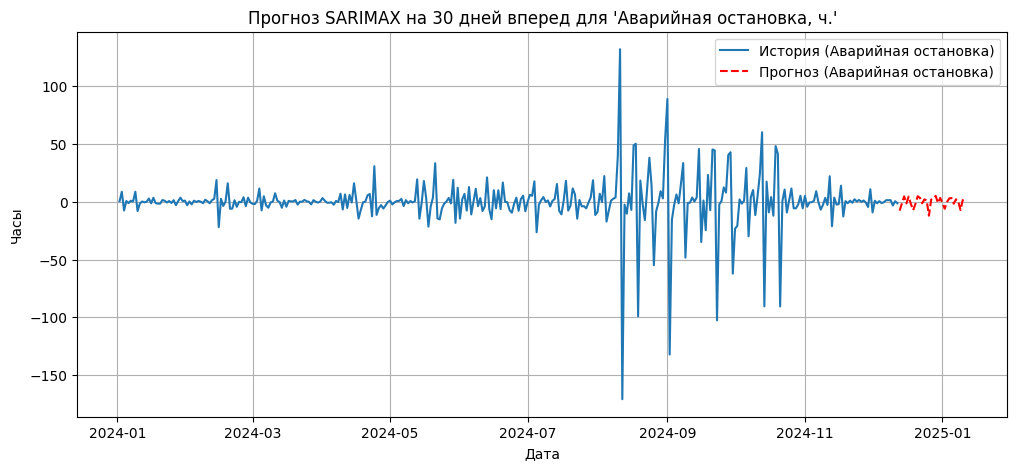

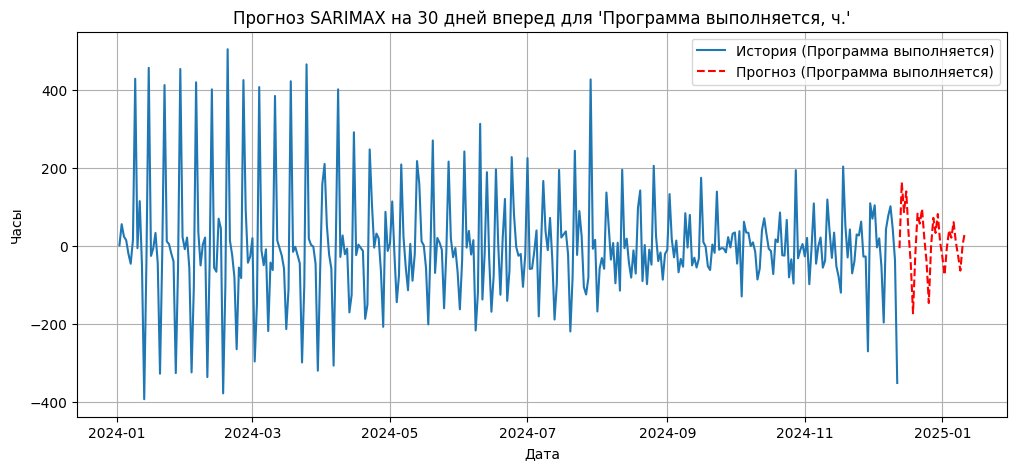

,Метрика,"Аварийная остановка, ч. (Будущий прогноз)","Программа выполняется, ч. (Будущий прогноз)"
0,MAE,4.915238,117.664434
1,RMSE,6.370066,149.832713


In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Определяем параметры модели
order_ao = (0, 0, 3)  # (p, d, q)
seasonal_order_ao = (2, 0, [1, 2], 7)  # (P, D, Q, s)
order_pv = (3, 0, 2)  # (p, d, q)
seasonal_order_pv = (1, 0, [1,3], 7)  # (P, D, Q, s)

# Обучаем SARIMAX для "Аварийная остановка, ч." с историческими экзогенными переменными
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=order_ao, 
                    seasonal_order=seasonal_order_ao, 
                    exog=df_aggregated[exog_columns_ao],  # Используем исторические данные
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

# Обучаем SARIMAX для "Программа выполняется, ч." с историческими экзогенными переменными
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=order_pv, 
                      seasonal_order=seasonal_order_pv, 
                      exog=df_aggregated[exog_columns_pv],  # Используем правильные экзогенные переменные
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Делаем прогноз на 30 дней вперед
forecast_ao = sarima_ao.predict(start=len(df_aggregated), end=len(df_aggregated)+29, exog=forecast_exog_df[exog_columns_ao])
forecast_pv = sarima_prog.predict(start=len(df_aggregated), end=len(df_aggregated)+29, exog=forecast_exog_df[exog_columns_pv])

# Визуализация прогноза
plt.figure(figsize=(12, 5))
plt.plot(df_aggregated["Аварийная остановка, ч."], label="История (Аварийная остановка)")
plt.plot(forecast_ao, label="Прогноз (Аварийная остановка)", linestyle="dashed", color="red")
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Прогноз SARIMAX на 30 дней вперед для 'Аварийная остановка, ч.'")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_aggregated["Программа выполняется, ч."], label="История (Программа выполняется)")
plt.plot(forecast_pv, label="Прогноз (Программа выполняется)", linestyle="dashed", color="red")
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Прогноз SARIMAX на 30 дней вперед для 'Программа выполняется, ч.'")
plt.legend()
plt.grid(True)
plt.show()


# Выводим краткие результаты моделей
summary_ao = sarima_ao.summary()
summary_prog = sarima_prog.summary()

summary_ao, summary_prog

# Вычисляем MAE и RMSE для "Аварийная остановка, ч."
mae_ao = mean_absolute_error(df_aggregated["Аварийная остановка, ч."].iloc[-30:], forecast_ao)
rmse_ao = np.sqrt(mean_squared_error(df_aggregated["Аварийная остановка, ч."].iloc[-30:], forecast_ao))

# Вычисляем MAE и RMSE для "Программа выполняется, ч."
mae_pv = mean_absolute_error(df_aggregated["Программа выполняется, ч."].iloc[-30:], forecast_pv)
rmse_pv = np.sqrt(mean_squared_error(df_aggregated["Программа выполняется, ч."].iloc[-30:], forecast_pv))

# Формируем таблицу с результатами
metrics_df = pd.DataFrame({
    "Метрика": ["MAE", "RMSE"],
    "Аварийная остановка, ч. (Будущий прогноз)": [mae_ao, rmse_ao],
    "Программа выполняется, ч. (Будущий прогноз)": [mae_pv, rmse_pv]
})

# Отображаем таблицу
metrics_df

# /////////////////////////////////////////////////////////////////////////


In [82]:
# Обучение модели SARIMAX БЕЗ экзогенных переменных для сравнения
sarima_ao_no_exog = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                            order=(0, 0, 3), 
                            seasonal_order=(2, 0, [1, 2], 7), 
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

sarima_pv_no_exog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                            order=(3, 0, 2), 
                            seasonal_order=(1, 0, [1,3], 7), 
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

# Прогноз без экзогенных переменных
forecast_ao_no_exog = sarima_ao_no_exog.predict(start=len(df_aggregated), end=len(df_aggregated)+29)
forecast_pv_no_exog = sarima_pv_no_exog.predict(start=len(df_aggregated), end=len(df_aggregated)+29)

# Вычисляем MAE и RMSE для модели без экзогенных переменных
mae_ao_no_exog = mean_absolute_error(df_aggregated["Аварийная остановка, ч."].iloc[-30:], forecast_ao_no_exog)
rmse_ao_no_exog = np.sqrt(mean_squared_error(df_aggregated["Аварийная остановка, ч."].iloc[-30:], forecast_ao_no_exog))

mae_pv_no_exog = mean_absolute_error(df_aggregated["Программа выполняется, ч."].iloc[-30:], forecast_pv_no_exog)
rmse_pv_no_exog = np.sqrt(mean_squared_error(df_aggregated["Программа выполняется, ч."].iloc[-30:], forecast_pv_no_exog))

# Формируем таблицу для сравнения
comparison_df = pd.DataFrame({
    "Метрика": ["MAE", "RMSE"],
    "С экзогенными (Аварийная остановка, ч.)": [mae_ao, rmse_ao],
    "Без экзогенных (Аварийная остановка, ч.)": [mae_ao_no_exog, rmse_ao_no_exog],
    "С экзогенными (Программа выполняется, ч.)": [mae_pv, rmse_pv],
    "Без экзогенных (Программа выполняется, ч.)": [mae_pv_no_exog, rmse_pv_no_exog]
})

# Отображаем таблицу пользователю
display(comparison_df)

,Метрика,"С экзогенными (Аварийная остановка, ч.)","Без экзогенных (Аварийная остановка, ч.)","С экзогенными (Программа выполняется, ч.)","Без экзогенных (Программа выполняется, ч.)"
0,MAE,4.915238,3.934632,117.664434,91.612300
1,RMSE,6.370066,6.136819,149.832713,121.822485


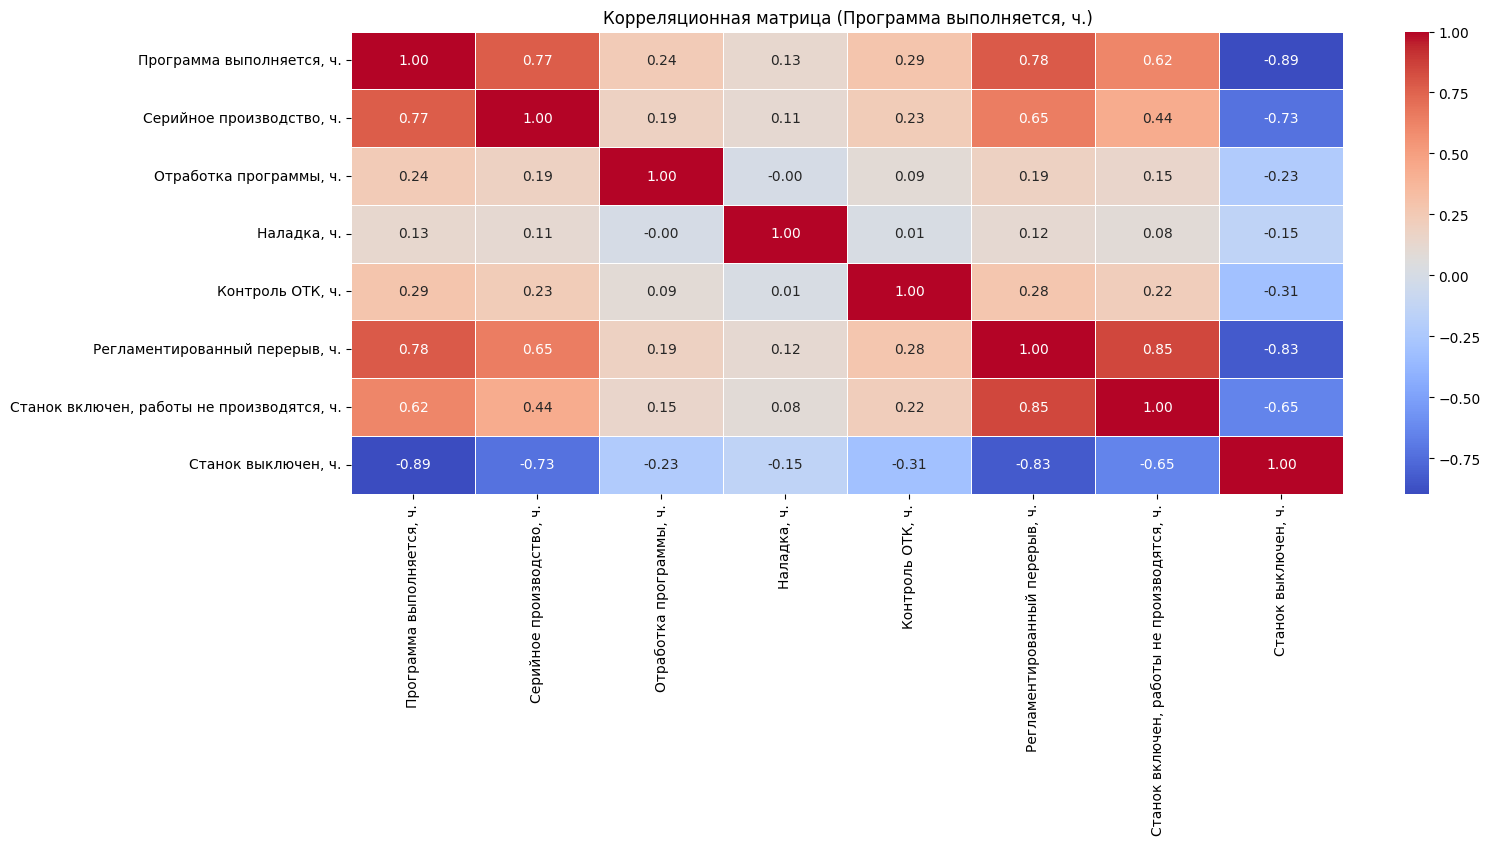

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление корреляции между целевыми и экзогенными переменными
# correlation_matrix_ao = df_aggregated[["Аварийная остановка, ч."] + df_aggregated.columns.drop(["Объект", "Аварийная остановка, ч.", "Программа выполняется, ч."]).to_list()].corr()
correlation_matrix_prog = df_aggregated[["Программа выполняется, ч."] + exog_columns_pv].corr()

# Визуализация корреляционной матрицы для "Аварийная остановка, ч."
# plt.figure(figsize=(16, 6))
# sns.heatmap(correlation_matrix_ao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Корреляционная матрица (Аварийная остановка, ч.)")
# plt.show()

# Визуализация корреляционной матрицы для "Программа выполняется, ч."
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_prog, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица (Программа выполняется, ч.)")
plt.show()


In [84]:
significant_exog_prog = correlation_matrix_prog["Программа выполняется, ч."].drop("Программа выполняется, ч.").abs()

significant_exog_prog = significant_exog_prog[significant_exog_prog > 0.2].index.tolist()

In [85]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.model_selection import train_test_split

# # Разделение данных на обучающую и тестовую выборку
# train_size = int(len(df_aggregated) * 0.8)
# train, test = df_aggregated.iloc[:train_size], df_aggregated.iloc[train_size:]

# # Выбираем экзогенные переменные на основе корреляционного анализа
# # significant_exog_prog = ["Серийное производство, ч.", "Станок выключен, ч.", 
# #                           "Станок включен, работы не производятся, ч.", "Регламентированный перерыв, ч."]

# # Обучаем SARIMAX
# sarimax_prog = SARIMAX(train["Программа выполняется, ч."], 
#                        order=(3, 0, 2), 
#                        seasonal_order=(1, 0, [1], 7), 
#                        exog=train[significant_exog_prog],
#                        enforce_stationarity=False,
#                        enforce_invertibility=False).fit()

# # Прогнозируем на тестовой выборке
# sarimax_pred = sarimax_prog.forecast(steps=len(test), exog=test[significant_exog_prog])

# # Вычисляем остатки (ошибки) SARIMAX
# residuals = train["Программа выполняется, ч."] - sarimax_pred

# # Обучаем XGBoost на предсказании остатков SARIMAX
# xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
# xgb.fit(test[significant_exog_prog], residuals)

# # Прогноз остатков XGBoost
# xgb_residuals_pred = xgb.predict(test[significant_exog_prog])

# # Итоговый прогноз ансамбля: SARIMAX + XGBoost
# ensemble_forecast = sarimax_pred + xgb_residuals_pred

# # Оценка точности моделей
# mae_sarimax = mean_absolute_error(test["Программа выполняется, ч."], sarimax_pred)
# rmse_sarimax = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], sarimax_pred))

# mae_ensemble = mean_absolute_error(test["Программа выполняется, ч."], ensemble_forecast)
# rmse_ensemble = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], ensemble_forecast))

# # Сравнение ошибок
# errors_comparison_df = pd.DataFrame({
#     "Метрика": ["MAE", "RMSE"],
#     "SARIMAX": [mae_sarimax, rmse_sarimax],
#     "Ансамбль SARIMAX + XGBoost": [mae_ensemble, rmse_ensemble]
# })

# # Отображение ошибок
# display(errors_comparison_df)

# # Визуализация прогнозов
# plt.figure(figsize=(12, 5))
# plt.plot(test.index, test["Программа выполняется, ч."], label="Фактические данные", alpha=0.7)
# plt.plot(test.index, sarimax_pred, label="Прогноз SARIMAX", linestyle="dashed", color="orange")
# plt.plot(test.index, ensemble_forecast, label="Ансамбль SARIMAX + XGBoost", linestyle="dashed", color="red")
# plt.xlabel("Дата")
# plt.ylabel("Часы")
# plt.title("Прогноз SARIMAX vs Ансамбль SARIMAX + XGBoost для 'Программа выполняется, ч.'")
# plt.legend()
# plt.grid(True)
# plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_2452\19660021.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f"lag_{lag}"] = train["Программа выполняется, ч."].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_2452\19660021.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f"lag_{lag}"] = test["Программа выполняется, ч."].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_2452\19660021.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,Метрика,SARIMAX,Ансамбль SARIMAX + XGBoost
0,MAE,82.741417,82.234119
1,RMSE,172.996926,172.992624


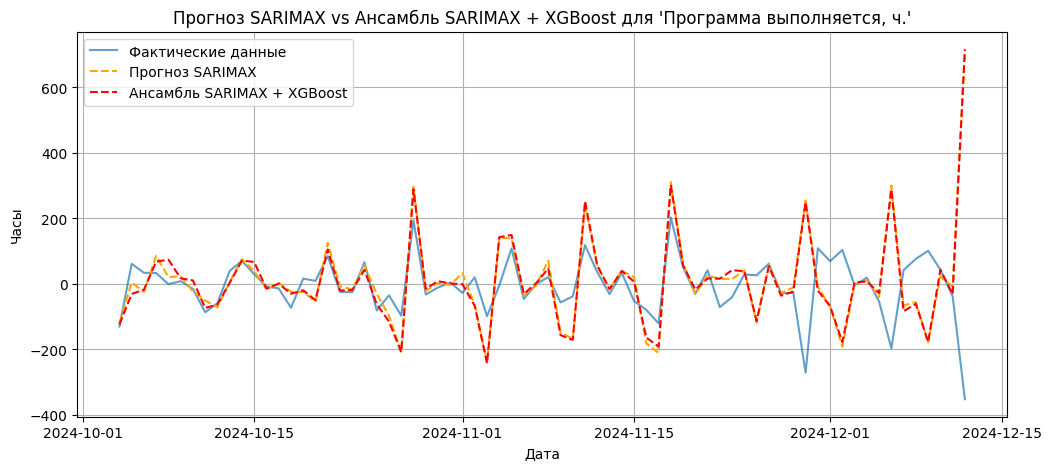

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Разделение данных
train_size = int(len(df_aggregated) * 0.8)
train, test = df_aggregated.iloc[:train_size], df_aggregated.iloc[train_size:]

# Добавляем лаги
lags = [1, 7, 14, 30]
for lag in lags:
    train[f"lag_{lag}"] = train["Программа выполняется, ч."].shift(lag)
    test[f"lag_{lag}"] = test["Программа выполняется, ч."].shift(lag)

# Выбираем экзогенные переменные
significant_exog_prog = ["Серийное производство, ч.", "Станок выключен, ч.", 
                          "Станок включен, работы не производятся, ч.", "Регламентированный перерыв, ч."]

# Обучаем SARIMAX
sarimax_prog = SARIMAX(train["Программа выполняется, ч."], 
                       order=(3, 0, 2), 
                       seasonal_order=(1, 0, 1, 7), 
                       exog=train[significant_exog_prog],
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

# Прогнозируем SARIMAX
sarimax_pred_train = sarimax_prog.predict(start=train.index[0], end=train.index[-1], exog=train[significant_exog_prog])
sarimax_pred_test = sarimax_prog.forecast(steps=len(test), exog=test[significant_exog_prog])

# Вычисляем остатки SARIMAX на train
residuals_train = train["Программа выполняется, ч."] - sarimax_pred_train

# Обучаем XGBoost на обучающей выборке (учитывая лаги)
xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb.fit(train[significant_exog_prog + [f"lag_{l}" for l in lags]], residuals_train)

# Прогноз XGBoost на тестовой выборке
xgb_residuals_pred = xgb.predict(test[significant_exog_prog + [f"lag_{l}" for l in lags]])

# Итоговый прогноз: SARIMAX + XGBoost
ensemble_forecast = sarimax_pred_test + xgb_residuals_pred

# Оценка точности
mae_sarimax = mean_absolute_error(test["Программа выполняется, ч."], sarimax_pred_test)
rmse_sarimax = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], sarimax_pred_test))

mae_ensemble = mean_absolute_error(test["Программа выполняется, ч."], ensemble_forecast)
rmse_ensemble = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], ensemble_forecast))

# Сравнение ошибок
errors_comparison_df = pd.DataFrame({
    "Метрика": ["MAE", "RMSE"],
    "SARIMAX": [mae_sarimax, rmse_sarimax],
    "Ансамбль SARIMAX + XGBoost": [mae_ensemble, rmse_ensemble]
})

# Отображение ошибок
display(errors_comparison_df)

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["Программа выполняется, ч."], label="Фактические данные", alpha=0.7)
plt.plot(test.index, sarimax_pred_test, label="Прогноз SARIMAX", linestyle="dashed", color="orange")
plt.plot(test.index, ensemble_forecast, label="Ансамбль SARIMAX + XGBoost", linestyle="dashed", color="red")
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Прогноз SARIMAX vs Ансамбль SARIMAX + XGBoost для 'Программа выполняется, ч.'")
plt.legend()
plt.grid(True)
plt.show()


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Очистка названий колонок перед LightGBM
train.columns = train.columns.str.replace(r"[^\w]", "", regex=True)
test.columns = test.columns.str.replace(r"[^\w]", "", regex=True)
# Очистка названий столбцов в списке экзогенных переменных
significant_exog_prog = [col.replace(" ", "").replace(",", "").replace(".", "").replace("-", "") for col in significant_exog_prog]

# Вывод обновленного списка
significant_exog_prog
display(test)


# Обучаем LightGBM
lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1)
lgb.fit(train[significant_exog_prog + [f"lag_{l}" for l in lags]], residuals_train)


# Разделение данных
train_size = int(len(df_aggregated) * 0.8)
train, test = df_aggregated.iloc[:train_size], df_aggregated.iloc[train_size:]



# Добавляем лаги (автоматический анализ)
lags = [1, 3, 7, 14, 30]
for lag in lags:
    train[f"lag_{lag}"] = train["Программа выполняется, ч."].shift(lag)
    test[f"lag_{lag}"] = test["Программа выполняется, ч."].shift(lag)

# Убираем NaN после сдвига
train.dropna(inplace=True)
test.dropna(inplace=True)

# # Выбираем экзогенные переменные
# significant_exog_prog = ["Серийное производство, ч.", "Станок выключен, ч.", 
#                           "Станок включен, работы не производятся, ч.", "Регламентированный перерыв, ч."]

# Обучаем SARIMAX
sarimax_prog = SARIMAX(train["Программа выполняется, ч."], 
                       order=(3, 0, 2), 
                       seasonal_order=(1, 0, 1, 7), 
                       exog=train[significant_exog_prog],
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

# Прогнозируем SARIMAX
sarimax_pred_train = sarimax_prog.predict(start=train.index[0], end=train.index[-1], exog=train[significant_exog_prog])
sarimax_pred_test = sarimax_prog.forecast(steps=len(test), exog=test[significant_exog_prog])

# Вычисляем остатки SARIMAX на train
residuals_train = train["Программа выполняется, ч."] - sarimax_pred_train

# Обучаем LightGBM на обучающей выборке (учитывая лаги)
lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1)
lgb.fit(train[significant_exog_prog + [f"lag_{l}" for l in lags]], residuals_train)

# Прогноз LightGBM на тестовой выборке
lgb_residuals_pred = lgb.predict(test[significant_exog_prog + [f"lag_{l}" for l in lags]])

# Итоговый прогноз: SARIMAX + LightGBM
ensemble_forecast = sarimax_pred_test + lgb_residuals_pred

# Оценка точности
mae_sarimax = mean_absolute_error(test["Программа выполняется, ч."], sarimax_pred_test)
rmse_sarimax = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], sarimax_pred_test))

mae_ensemble = mean_absolute_error(test["Программа выполняется, ч."], ensemble_forecast)
rmse_ensemble = np.sqrt(mean_squared_error(test["Программа выполняется, ч."], ensemble_forecast))

# Анализ важности признаков LightGBM
feature_importances = pd.Series(lgb.feature_importances_, index=significant_exog_prog + [f"lag_{l}" for l in lags])
feature_importances.sort_values(ascending=False, inplace=True)

# Отображение ошибок
errors_comparison_df = pd.DataFrame({
    "Метрика": ["MAE", "RMSE"],
    "SARIMAX": [mae_sarimax, rmse_sarimax],
    "Ансамбль SARIMAX + LightGBM": [mae_ensemble, rmse_ensemble]
})

display(errors_comparison_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 4))
feature_importances.plot(kind="bar", title="Важность признаков LightGBM")
plt.show()

# Визуализация прогнозов
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["Программа выполняется, ч."], label="Фактические данные", alpha=0.7)
plt.plot(test.index, sarimax_pred_test, label="Прогноз SARIMAX", linestyle="dashed", color="orange")
plt.plot(test.index, ensemble_forecast, label="Ансамбль SARIMAX + LightGBM", linestyle="dashed", color="red")
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Прогноз SARIMAX vs Ансамбль SARIMAX + LightGBM для 'Программа выполняется, ч.'")
plt.legend()
plt.grid(True)
plt.show()


,Объект,Аварийная_остановка__ч_,Прогрев_станка__ч_,Серийное_производство__ч_,Отработка_программы__ч_,Ручной_режим__ч_,Программа_выполняется__ч_,Авария__ч_,Отсутствие_КД_модели__ч_,Наладка__ч_,...,Ремонтные_работы__ч_,ППР__ч_,Регламентированный_перерыв__ч_,Уборка_оборудования__ч_,Станок_включен__работы_не_производятся__ч_,Станок_выключен__ч_,lag_1,lag_7,lag_14,lag_30
Дата,,,,,,,,,,,,,,,,,,,,,
2024-10-04,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-1.635000,1.049,-42.492000,38.115000,0.000,-130.464,0.0,0.0,4.010,...,0.0,0.0,-3.201000,0.298,-237.644000,146.897000,NaN,NaN,NaN,NaN
2024-10-05,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,0.772000,0.000,17.782000,36.450000,0.000,60.939,0.0,0.0,2.487,...,0.0,0.0,3.753000,0.047,264.678000,-47.619000,-130.464,NaN,NaN,NaN
2024-10-06,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,29.165000,0.000,-45.534000,40.242000,0.000,33.462,0.0,0.0,0.000,...,0.0,0.0,4.841000,0.000,245.434000,38.824000,60.939,NaN,NaN,NaN
2024-10-07,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-29.884000,0.876,8.910000,24.177000,0.000,32.637,0.0,0.0,0.000,...,0.0,0.0,-1.020000,0.315,-241.407000,-68.100000,33.462,NaN,NaN,NaN
2024-10-08,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,3.997000,4.087,32.688000,20.063000,0.075,-1.342,0.0,0.0,3.517,...,0.0,0.0,-0.891000,0.243,-13.558000,-22.047000,32.637,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-08,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.284667,1.602,67.680667,26.270667,0.000,75.986,0.0,0.0,0.000,...,0.0,0.0,3.299333,0.000,62.506667,72.957333,41.878,68.952,28.372667,20.505
2024-12-09,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,1.388667,9.387,45.164667,28.891000,0.000,100.738,0.0,0.0,0.000,...,0.0,0.0,1.940333,0.000,108.967667,28.593333,75.986,103.263,25.867667,-56.748
2024-12-10,DMG Sprint 20/8 (Е33-125Ф6)DMG Sprint 20/8 (Е3...,-3.287000,0.000,12.987000,22.514000,0.000,42.992,0.0,0.0,0.000,...,0.0,0.0,-0.158000,0.030,1.457000,-30.575000,100.738,-4.732,61.336000,-38.499


KeyError: "['Серийноепроизводствоч', 'Станоквыключенч', 'Станоквключенработынепроизводятсяч', 'Регламентированныйперерывч'] not in index"